# Diferenciação automática

A diferenciação automática é uma técnica para calcular e propagar derivadas usando a regra da cadeia, que é a principal operação de qualquer rede neural usando o algoritmo de retropropagação e gradiente descendente. 

Para entender melhor este notebook, leia as Seções 1.2.1 a 1.2.3 das [notas de aula](<../Notas de Aula.pdf>)

### Diferenciação automática utilizando Pytorch

In [17]:
import torch

# Cria um tensor com valor 1. requires_grad=True significa que queremos
# calcular o gradiente em relação a essa variável.
x = torch.tensor(1., requires_grad=True)
y = 4*x**2

# Calcula o gradiente de y em relação a x.
y.backward()

# A componente dy/dx do gradiente é armazenada como o atributo .grad da variável x
dydx = x.grad

# dydx = 8*x = 8
print(dydx)

tensor(8.)


Vamos calcular o gradiente para uma expressão mais complexa:

$
\large
y = x_1*x_2 + x_3^2 - \frac{x_4}{x_2}
$

O gradiente de y é dado por

$
\large
\nabla y = (\frac{\partial{y}}{\partial{x1}}, \frac{\partial{y}}{\partial{x2}}, \frac{\partial{y}}{\partial{x3}}, \frac{\partial{y}}{\partial{x4}})
$

In [18]:
def function(x1, x2, x3, x4):

    y = x1*x2 + x3**2 - x4/x2
    return y

def gradient(y, x1, x2, x3, x4):
    
    y.backward()
    gradient = [x1.grad, x2.grad, x3.grad, x4.grad]
    return gradient

x1 = torch.tensor(2., requires_grad=True)
x2 = torch.tensor(3., requires_grad=True)
x3 = torch.tensor(1., requires_grad=True)
x4 = torch.tensor(4., requires_grad=True)

y = function(x1, x2, x3, x4)
grad = gradient(y, x1, x2, x3, x4)

dydx1, dydx2, dydx3, dydx4 = grad

# dydx1 = x2 = 3
print(dydx1)

# dydx2 = x1 + x4/x2**2 = 2 + 4/9 = 2.4444
print(dydx2)

# dydx3 = 2*x3 = 2
print(dydx3)

# dydx4 = -1/x2 = -0.33333
print(dydx4)

tensor(3.)
tensor(2.4444)
tensor(2.)
tensor(-0.3333)


O método y.backward() calcula o gradiente de y em relação à todas as variáveis que seguem os seguintes critérios:
1. A variável foi utilizada para calcular y
2. A variável possui o atributo requires_grad=True
3. A variável é folha do grafo de computação, ou seja, ela não foi calculada a partir de nenhuma outra variável com requires_grad=True

Caso a derivada de alguma variável intermediária seja necessária para calcular o gradiente, o Pytorch também calcula essa derivada. Mas assim que o valor não for mais necessário a derivada é apagada da memória, e apenas as derivadas em relação às variáveis folha são mantidos.

Podemos também calcular o gradiente de funções compostas, isto é, funções (ou variáveis) que dependem de outras funções:

$
\begin{align}
& y(x) = 3*x^2 \\
& z(y) = y^4 \\
\end{align}
$

$
\begin{align}
\frac{\partial{z}}{\partial{x}} & = \frac{\partial{z}}{\partial{y}}\frac{\partial{z}}{\partial{x}} \\
\frac{\partial{z}}{\partial{x}} & = 4*y^3 * 6*x
\end{align}
$

In [19]:
def y_func(x):
    return 3*x**2

def z_func(y):
    return y**4

x = torch.tensor(2., requires_grad=True)
y = y_func(x)
z = z_func(y)

# Como mencionado, o Pytorch mantém apenas o gradiente de variáveis folha 
# (x no nosso caso). Para podermos acessar o gradiente de uma variável não-folha 
# precisamos indicar explicitamente que queremos manter o gradiente da variável 
# usando o método .retain_grad()
y.retain_grad() 
z.backward()

# dzdx = 4*y**3*6*x = (4*12**3)*6*2 = 82944
print(x.grad)

# dzdy = 4*y**3 = 4*12**3 = 6912
print(y.grad)

tensor(82944.)
tensor(6912.)


Internamente o Pytorch cria um *grafo de computação* que armazena todas as informações necessárias para calcular o gradiente de qualquer variável. O grafo possui nós associados às variáveis, e cada nó possui as informações necessárias para calcular a derivada do valor de saída do nó em relação aos valores de entrada. Essas informações podem ser acessadas através do atributo .grad_fn

![](../data/notebook_images/autograd.png)

In [20]:
x = torch.tensor(2., requires_grad=True)
y = torch.tensor(5., requires_grad=True)
z = x*y

print(z.grad_fn)
print(z.grad_fn._saved_other)
print(z.grad_fn._saved_self)

tensor(5., requires_grad=True)
tensor(2., requires_grad=True)


In [21]:
dzdx, dzdy = z.grad_fn(torch.tensor(1.))
print(dzdx, dzdy)

tensor(5., grad_fn=<MulBackward0>) tensor(2., grad_fn=<MulBackward0>)


### Detalhes importantes ao trabalhar com o Pytorch

#### Acúmulo de gradientes

In [22]:
# Parâmetro do modelo
w = torch.tensor(1., requires_grad=True)
# Dados de entrada
data = [4, 7, 2, 8]
# Ilustração de parte de um loop de treinamento. Para cada dado, calculamos a saída e o gradiente.
for x in data:
    y = w*x
    y.backward()
    print(w.grad)

tensor(4.)
tensor(11.)
tensor(13.)
tensor(21.)


Note que o gradiente está sempre aumentando, o que não é o esperado. Isso ocorre porque o Pytorch **sempre acumula os gradientes** a cada vez que o método .backward() é chamado. Em outras palavras, ele faz algo como:

dydx = calculate_gradient(y, x)\
x.grad += dydx

Se não desejamos acumular os gradientes, o que é o caso em geral, devemos sempre apagar os gradientes antes de chamar .backward() novamente:

In [23]:
w = torch.tensor(1., requires_grad=True)
data = [4, 7, 2, 8]
for x in data:
    # Remove o gradiente anteriormente computado, se existir. Poderíamos também utilizar
    # w.grad = torch.tensor(0.), mas atribuir a None proporciona uma performance um pouco melhor
    w.grad = None
    y = w*x
    y.backward()
    print(w.grad)

tensor(4.)
tensor(7.)
tensor(2.)
tensor(8.)


#### Modificando um tensor que possui requires_grad=True

In [24]:
w = torch.tensor(1., requires_grad=True)
data = [4, 7, 2, 8]
lr = 0.1
# Ilustração de parte de um loop de treinamento, agora também com a atualização do
# parâmetro do modelo de acordo com o gradiente calculado. 
for x in data:
    w.grad = None
    y = w*x
    y.backward()
    # O comando abaixo dará erro. Foi adicionado um try para o notebook poder executar
    try:
        w -= lr*w.grad
    except RuntimeError as re:
        print(re)

a leaf Variable that requires grad is being used in an in-place operation.
a leaf Variable that requires grad is being used in an in-place operation.
a leaf Variable that requires grad is being used in an in-place operation.
a leaf Variable that requires grad is being used in an in-place operation.


O código acima dá erro. A princípio o erro pode parecer confuso, mas podemos entendê-lo ao pensar no grafo que o Pytorch constrói para calcular os gradientes.

O termo **leaf variable** está relacionado à variável `w`. Ela é chamada de variável folha porque ela não é calculada a partir de outras variáveis, isto é, ela é definida com um valor inicial utilizando a função torch.tensor(). O Pytorch precisa saber o valor dessa variável ao calcular os gradientes, pois ele pode ser necessário ao aplicar a regra da cadeia.

A operação `w -= valor` é uma operação in-place. Ela modifica o valor do tensor. Com isso, se o Pytorch permitisse essa operação, não teria como ele acessar o valor da variável. Por isso ele evita que isso ocorra dando erro.

Ao invés de usar `w -= valor`, poderíamos atualizar o valor de outra forma:

In [25]:
w = torch.tensor(1., requires_grad=True)
data = [4, 7, 2, 8]
lr = 0.1
for x in data:
    w.grad = None
    y = w*x
    y.backward()
    try:
        w = w - lr*w.grad
    except TypeError as te:
        print(te)

unsupported operand type(s) for *: 'float' and 'NoneType'
unsupported operand type(s) for *: 'float' and 'NoneType'
unsupported operand type(s) for *: 'float' and 'NoneType'


/tmp/ipykernel_59832/2045425795.py:9: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1741947884212/work/build/aten/src/ATen/core/TensorBody.h:489.)
  w = w - lr*w.grad


Erro novamente? Agora o problema é outro. É importante lembrar que qualquer operação envolvendo um tensor que requer gradiente é armazenada no grafo de computação. Ao fazer `w = w - lr*w.grad`, estamos criando uma nova variável chamada `w` cujo valor é dado por `w - lr*w.grad`. Isso faz com que `w` não seja mais uma variável folha, e não podemos mais acessar o atributo .grad dela.

Mais importante, não tem porque registrarmos a operação `w = w - lr*w.grad` no grafo de computação. Queremos apenas atualizar o valor do gradiente. Essa operação nunca será utilizada no cálculo de gradiente. Portanto, para essa operação em particular, devemos evitar de registrá-la no grafo:

In [26]:
w = torch.tensor(1., requires_grad=True)
data = [4, 7, 2, 8]
lr = 0.1
for x in data:
    w.grad = None
    y = w*x
    y.backward()
    # Contexto Python. Todo código dentro do contexto não será registrado para o 
    # cálculo do gradiente
    with torch.no_grad():
        w -= lr*w.grad
    print(w)

tensor(0.6000, requires_grad=True)
tensor(-0.1000, requires_grad=True)
tensor(-0.3000, requires_grad=True)
tensor(-1.1000, requires_grad=True)


#### Copiando dados e removendo um tensor do grafo de computação

In [27]:
x = torch.randn(100, requires_grad=True)

# Copia os dados de x para y. Note que a cópia é incluída no grafo de computação. 
y = torch.clone(x)

# Define um novo tensor, removendo ele do cálculo de gradientes. Importante! Os dados
# dos dois tensores são compartilhados. Não modifique o tensor y, pois pode levar
# a erros no cálculo do gradiente
y = x.detach()

# Remove o tensor do grafo e copia os valores. Comando ideal para copiar valores
y = x.detach().clone()

# Equivalente ao código acima
with torch.no_grad():
    y = x.clone()

# Não recomendado. Cria um novo tensor com requires_grad=False copiando os dados de x 
#y = torch.tensor(x)

In [28]:
x = torch.randn(100, requires_grad=True)
print(x.requires_grad)

# Remove o tensor do grafo
x.requires_grad = False

# Equivalente ao comando acima 
x.requires_grad_(False)

# Conversão entre o pytorch e numpy. Importante! As variáveis compartilham a memória. 
# A alteração em uma variável altera a outra. Outra coisa, a conversão dará erro se
# o tensor possuir requires_grad=True
y = x.numpy()
z = torch.from_numpy(y)

# Tensores possuindo um único valor podem ser transformados em um valor Python
# através do método .item()
soma = x.sum().item()

True


### Exemplo de implementação de diferenciação automática

A célula abaixo utiliza uma classe bem simples chamada `Value` que mostra como implementar diferenciação automática. A classe está implementada no arquivo `autodiff.py` localizado no mesmo diretório deste notebook. Não é necessário executar ela para executar o resto do notebook. Ela está aqui apenas para mostrar como a diferenciação automática pode ser implementada.

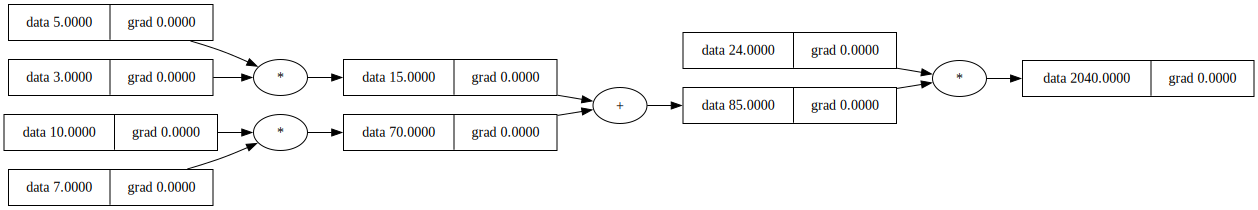

In [29]:
from autodiff import Value, draw_dot

x1 = Value(5.0)
x2 = Value(7.0)
y = 3*x1 + 10*x2
z = 24*y
draw_dot(z)

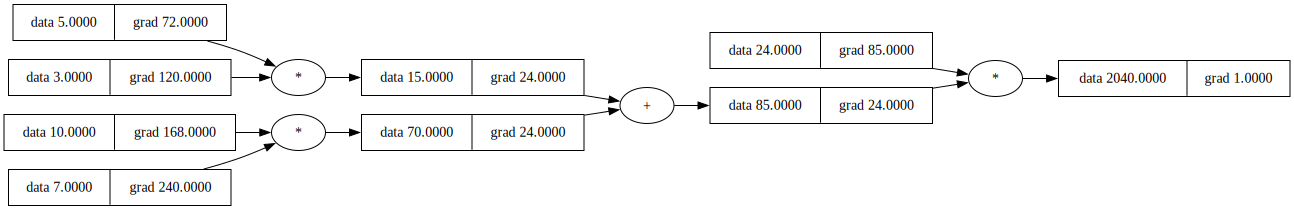

In [30]:
z.backward()
draw_dot(z)

### Regressão linear usando diferenciação automática

Tendo uma forma de calcular gradientes, podemos reimplementar a regressão linear

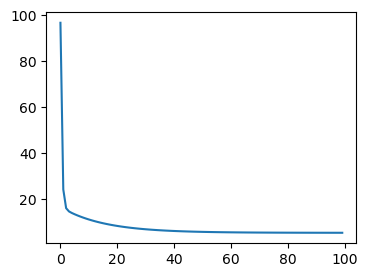

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch


class Model:

    def __init__(self, a, b):

        # Parâmetros do modelo
        self.a = torch.tensor(a, requires_grad=True)
        self.b = torch.tensor(b, requires_grad=True)

    def __call__(self, x):
        y = self.a*x + self.b
        return  y

def mse(model, x, y):
    """Erro quadrático médio"""

    ym = model(x)
    error = torch.mean((y-ym)**2)

    return error

def step(model, x, y, lr):

    # Apaga os gradientes
    model.a.grad = None
    model.b.grad = None
    error = mse(model, x, y)
    # Calcula os gradientes
    error.backward()
    # Atualiza os gradientes
    with torch.no_grad():
        model.a -= lr*model.a.grad
        model.b -= lr*model.b.grad

    return error.item()

def train(model, x, y, lr, num_epochs):

    errors = []
    for epoch in range(0, num_epochs):
        error = step(model, x, y, lr)
        errors.append(error)

    return errors

data = torch.from_numpy(np.loadtxt("../data/age_data_1.txt"))
x, y = data.T

model = Model(a=0., b=0.)
num_epochs = 100
lr = 0.3
errors = train(model, x, y, lr, num_epochs)

plt.plot(errors)